# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
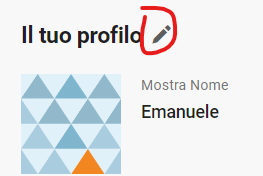 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import dask.dataframe as dd

## Client

In [2]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


Pandas va installato anche se si installa prima Dask

Function to create a client session with the API using the token:

In [3]:
def connect_ARPA_api(token):
    """
    Function to connect to ARPA API.

        Parameters:
            - token (str): the ARPA token obtained from Open Data Lombardia website

        Returns:
            - client: client session
            
    """
    client = Socrata("www.dati.lombardia.it", app_token=token)

    return client

Import the code of the dataset. In this case "nf78-nj6b" is related to ARPA stations information containing:
1) sensors id
2) sensor type
3) unit
4) stations id
5) stations names
...

## Stations and sensors information

In [4]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
client = connect_ARPA_api(arpa_token)
sensors_info = client.get_all(stationsId)

Create sensors dataframe:

In [5]:
def ARPA_sensors_info(sensors_info):
    
    sensors_df = pd.DataFrame(sensors_info)
    sensors_df['idsensore']=sensors_df['idsensore'].astype(int)
    sensors_df['idstazione']=sensors_df['idstazione'].astype(int)
    sensors_df['datastart']=pd.to_datetime(sensors_df['datastart'])
    sensors_df['datastop']=pd.to_datetime(sensors_df['datastop'])
    
    
    
    return sensors_df

In [6]:
sensors_df = ARPA_sensors_info(sensors_info)

In [7]:
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaT
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT


In [8]:
unique_sensors_list = sensors_df['tipologia'].unique()
unique_sensors_list

array(['Precipitazione', 'Temperatura', 'Umidità Relativa',
       'Radiazione Globale', 'Direzione Vento', 'Velocità Vento',
       'Livello Idrometrico', 'Altezza Neve'], dtype=object)

In [9]:
# #Check sensori storici
# sensors_df.loc[sensors_df['storico'] == 'S']

Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [10]:
sensor_sel = "Temperatura"
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list = list(map(int, sensors_list))

In [11]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


----

## API Time series
This part requires time series and relative information from the API. The output of this section is to obtain a dataframe that has the same characteristics as the dataframe obtained from the csv processing.

In [12]:
def req_ARPA_start_end_date_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

      Parameters:
        - client: the client session

      Returns: 
        - start_API_date (str): starting date for available data inside the API.
        - end_API_date (str): ending date for available data inside the API.
        
    """
    weather_sensor_id = "647i-nhxk" #Weather sensors id
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    min_max_dates = client.get(weather_sensor_id, query=query)[0] #Get max and min dates from the list
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    
    print("The data from the API are available from: " ,start_API_date, " up to: ", end_API_date)

    return start_API_date, end_API_date

In [13]:
start_date_API, end_date_API = req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-01-01 00:00:00  up to:  2023-01-23 11:50:00


In [14]:
start_date_API, end_date_API

(datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 23, 11, 50))

In [15]:
#In this way can be manually defined otherwise minimum and max dates are selected as previsously shown
start_date_API = "2023-01-17 05:00:00"
end_date_API = "2023-01-19 10:00:00"
start_date_API = datetime.strptime(start_date_API, "%Y-%m-%d %H:%M:%S")
end_date_API = datetime.strptime(end_date_API, "%Y-%m-%d %H:%M:%S")
start_date_API, end_date_API

(datetime.datetime(2023, 1, 17, 5, 0), datetime.datetime(2023, 1, 19, 10, 0))

Function to request the time series from the API in the time range considered:

In [16]:
def req_ARPA_data_API(client, start_date, end_date, sensors_list):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

      Parameters:
        - client: the client session
        - start date (str): the start date in yyy-mm-dd format
        - end date (str): the end date in yyy-mm-dd format
        - sensors_list(str): list of sensors selected to be used as filter
        
      Returns: 
        - time_series: time series of values requested with the query for all sensors
        
    """
    weather_sensor_id = "647i-nhxk"
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
    t = time.time()
    
    print("Starting request to ARPA API")
    
    query = """
      select
          *
      where data >= \'{}\' and data <= \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    time_series = client.get(weather_sensor_id, query=query)
    print(time_series)
    elapsed = time.time() - t
    print("Time used for requesting the data from ARPA API: ", elapsed)
    
    #Create dataframe
    sensors_values_df_API = pd.DataFrame(time_series, columns=['idsensore','data','valore'])
    
    #Convert types
    sensors_values_df_API['valore'] = sensors_values_df_API['valore'].astype(float)
    sensors_values_df_API['idsensore'] = sensors_values_df_API['idsensore'].astype(int)
    sensors_values_df_API['data'] = pd.to_datetime(sensors_values_df_API['data'])
    sensors_values_df_API = sensors_values_df_API.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    #Filter with selected sensors list
    sensors_values_df_API = sensors_values_df_API[sensors_values_df_API['idsensore'].isin(sensors_list)]

    return sensors_values_df_API

Output dataframe:
- idsensore (int)
- data (datetime)
- valore (float)

In [17]:
sensors_values_API = req_ARPA_data_API(client, start_date_API, end_date_API, sensors_list)

Starting request to ARPA API


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
sensors_values_API.dtypes

idsensore             int32
data         datetime64[ns]
valore              float64
dtype: object

Final dataframe:

In [19]:
sensors_values_API

,idsensore,data,valore
1,9003,2023-01-17 05:00:00,-4.1
5,14317,2023-01-17 05:00:00,-0.8
37,19363,2023-01-17 05:00:00,1.6
38,8123,2023-01-17 05:00:00,1.0
65,9310,2023-01-17 05:00:00,3.7
...,...,...,...
363259,17460,2023-01-19 10:00:00,1.5
363265,4058,2023-01-19 10:00:00,1.2
363267,5911,2023-01-19 10:00:00,1.6
363270,2433,2023-01-19 10:00:00,1.4


---

## Time series from csv files
The output of this sections is a dataframe that has the same characteristics of the time series obtained with the API.

In [20]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

            Parameters:
                year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

            Returns:
                None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    #If yrar.csv file is already downloaded, skip download
    if not os.path.exists("2022.csv"):

        print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
        req = requests.get(url)

        # Writing the file to the local file system
        with open(filename,'wb') as output_file:
            output_file.write(req.content)
        print(('Downloading {filename} -> Completed').format(filename = filename))

        print(("Starting unzipping: {filename}").format(filename=filename))
        #Loading the .zip and creating a zip object
        with ZipFile(filename, 'r') as zObject:
            # Extracting all the members of the zip into a specific location
            zObject.extractall()

        csv_file=str(year)+'.csv'
        print(("File unzipped: {filename}").format(filename=filename))
        print(("File csv saved: {filename}").format(filename=csv_file))

        #Remove the zip folder
        if os.path.exists(filename):
            print("Zip folder removed")
            os.remove(filename)
        else:
            print(("The file {filename} does not exist in this folder").format(filename=filename))
    
    else:
        print(year+".csv already exists. It won't be downloaded.")

In [21]:
year = 2022
csv_file = str(year)+'.csv'

Make an if that it doenst download the file if the csv is already present.

In [22]:
download_extract_csv_from_year(str(year))

2022.csv already exists. It won't be downloaded.


In [23]:
start_date_csv = str(year)+"-01-01 05:00:00"
end_date_csv = str(year)+"-12-31 10:00:00"
start_date_csv = datetime.strptime(start_date_csv, "%Y-%m-%d %H:%M:%S")
end_date_csv = datetime.strptime(end_date_csv, "%Y-%m-%d %H:%M:%S")
start_date_csv, end_date_csv

(datetime.datetime(2022, 1, 1, 5, 0), datetime.datetime(2022, 12, 31, 10, 0))

Create a function that prepares the dataframe. Function to process the csv file using Dask library to manage big files. 
- proper columns names like the API ones
- removes useless columns
- converts to rfifodata tydd
- filters over the time range
- filters with selected sensor list
- compute dask dataframe

In [24]:
def process_ARPA_csv(csv_file, start_date, end_date, sensors_list):
    """
    This function reads the ARPA csv file into a dask dataframe and provided a computed dataframe. It renames the columns like the API columns names, filters between provided dates and select the sensors present in the list.

            Parameters:
                csv_file(str): name of the csv file
                start_date(datetime): start date for processing
                end_date(datetime): end date for processing
                sensors_list(string list): list of selected sensors

            Returns:
                df(dataframe): computed filtered dask dataframe
    """
    
    print(("The time range is {start_date} to {end_date}").format(start_date=start_date,end_date=end_date))
    #Read csv file with Dask dataframe
    df = dd.read_csv(csv_file, usecols=['IdSensore','Data','Valore']) 
    
    #Make csv columns names equal to API columns names
    df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})
    
    #Type formatting
    df['valore'] = df['valore'].astype(float)
    df['idsensore'] = df['idsensore'].astype(int)
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    
    #Filter using the dates
    df = df.loc[(df['data'] >= start_date) & (df['data'] <= end_date)]
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    #Filter on temperature sensors list
    sensors_list = list(map(int, sensors_list))
    df = df[df['idsensore'].isin(sensors_list)]
    
    print("Starting computing dataframe")
    #Compute df
    t = time.time()
    df = df.compute()
    elapsed = time.time() - t
    print("Time used for computing dataframe: ", elapsed)
    
    return df 

In [25]:
sensors_values_csv = process_ARPA_csv(csv_file, start_date_csv, end_date_csv, sensors_list)

The time range is 2022-01-01 05:00:00 to 2022-12-31 10:00:00
Starting computing dataframe
Time used for computing dataframe:  22.33697247505188


In [26]:
sensors_values_csv.dtypes

idsensore             int32
data         datetime64[ns]
valore              float64
dtype: object

Final dataframe:

In [27]:
sensors_values_csv

,idsensore,data,valore
34565,53,2022-01-01 05:00:00,5.9
34577,115,2022-01-01 05:00:00,7.4
34580,121,2022-01-01 05:00:00,15.4
34591,2001,2022-01-01 05:00:00,0.0
34595,2039,2022-01-01 05:00:00,0.7
...,...,...,...
1900169,12025,2022-12-31 09:00:00,6.2
1900305,5890,2022-12-31 10:00:00,7.5
1900309,5863,2022-12-31 10:00:00,6.7
1900315,6992,2022-12-31 10:00:00,6.1


## Data aggregation

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)



In [28]:
def aggregate_group_data(df, temporal_agg="D", agg="mean"):

    """
    This function aggregates ARPA data with providing a temporal aggregation (day, week etc.) and a statistical aggregration function (mean, max, min etc.). The dataframe is grouped by sensor id (idsensore).

            Parameters:
                df(dataframe): ARPA dataframe containing the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                temporal_agg(str): the temporal aggregation accepted by the resample() method (D, M, Y or others)
                agg(str): the statistical aggregation to be performed (mean, max, min etc.)

            Returns:
                df(dataframe): computed filtered and aggregated dask dataframe
    """
    
    print("Number of sensors available in the dataframe: ", len(df.idsensore.unique()))
    print("Aggregation function: " + agg)
    print("Temporal aggregation: " + temporal_agg)
    df = df.set_index('data')
          
    grouped = df.groupby('idsensore').resample(str(temporal_agg))['valore'].agg(str(agg))
    grouped = grouped.reset_index()
    
    return grouped

Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

In [56]:
sensor_test_agg = aggregate_group_data(sensors_values_csv, "D", "mean")

Number of sensors available in the dataframe:  197
Aggregation function: mean
Temporal aggregation: D


In [57]:
sensor_test_agg

,idsensore,data,valore
0,53,2022-01-01,7.901754
1,53,2022-01-02,5.057639
2,53,2022-01-03,3.887500
3,53,2022-01-04,0.181944
4,53,2022-01-05,-1.530556
...,...,...,...
69886,32401,2022-12-18,NaN
69887,32401,2022-12-19,NaN
69888,32401,2022-12-20,NaN
69889,32401,2022-12-21,1.801639


## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [58]:
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaT
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT


In [59]:
sensor_test_agg

,idsensore,data,valore
0,53,2022-01-01,7.901754
1,53,2022-01-02,5.057639
2,53,2022-01-03,3.887500
3,53,2022-01-04,0.181944
4,53,2022-01-05,-1.530556
...,...,...,...
69886,32401,2022-12-18,NaN
69887,32401,2022-12-19,NaN
69888,32401,2022-12-20,NaN
69889,32401,2022-12-21,1.801639


In [60]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')

In [61]:
merged_df

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,53,2022-01-01,7.901754,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
1,53,2022-01-02,5.057639,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
2,53,2022-01-03,3.887500,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
3,53,2022-01-04,0.181944,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
4,53,2022-01-05,-1.530556,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69886,32401,2022-12-18,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
69887,32401,2022-12-19,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
69888,32401,2022-12-20,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
69889,32401,2022-12-21,1.801639,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT


In [62]:
measure_unit = merged_df['unit_dimisura'].unique()[0]

In [63]:
measure_unit

'°C'

In [64]:
min_index = merged_df['valore'].idxmin()
idsensor_min = merged_df.loc[min_index].idsensore
merged_df.loc[min_index]

idsensore                                                                  17432
data                                                         2022-11-26 00:00:00
valore                                                                -33.170833
tipologia                                                            Temperatura
unit_dimisura                                                                 °C
idstazione                                                                  1862
nomestazione                                                               Broni
quota                                                                         77
provincia                                                                     PV
datastart                                                    2018-03-22 00:00:00
storico                                                                        N
cgb_nord                                                                 4987916
cgb_est                     

In [65]:
max_index = merged_df['valore'].idxmax()
idsensor_max = merged_df.loc[max_index].idsensore
merged_df.loc[max_index]

idsensore                                                                  17573
data                                                         2022-05-22 00:00:00
valore                                                                 61.306944
tipologia                                                            Temperatura
unit_dimisura                                                                 °C
idstazione                                                                  1880
nomestazione                                                     Lomello Cantona
quota                                                                         84
provincia                                                                     PV
datastart                                                    2018-12-05 00:00:00
storico                                                                        N
cgb_nord                                                                 4996463
cgb_est                     

## Test and plotting

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

Select a specific sensor:

In [67]:
sel_sensor_min = sensor_test_agg.loc[sensor_test_agg['idsensore']==idsensor_min]
sel_sensor_max = sensor_test_agg.loc[sensor_test_agg['idsensore']==idsensor_max]

In [68]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(sel_sensor_max)

       idsensore       data     valore
61945      17573 2022-01-01   2.461404
61946      17573 2022-01-02   2.743750
61947      17573 2022-01-03   3.153472
61948      17573 2022-01-04   5.740278
61949      17573 2022-01-05   6.589583
61950      17573 2022-01-06   4.328472
61951      17573 2022-01-07   0.155556
61952      17573 2022-01-08  -1.250694
61953      17573 2022-01-09   0.273611
61954      17573 2022-01-10  -1.240278
61955      17573 2022-01-11  -0.054861
61956      17573 2022-01-12  -0.129861
61957      17573 2022-01-13  -0.386806
61958      17573 2022-01-14   1.338194
61959      17573 2022-01-15   2.082639
61960      17573 2022-01-16   2.011111
61961      17573 2022-01-17   3.585714
61962      17573 2022-01-18   2.096479
61963      17573 2022-01-19   1.932639
61964      17573 2022-01-20   3.488194
61965      17573 2022-01-21  -0.570833
61966      17573 2022-01-22   2.191667
61967      17573 2022-01-23  -0.433333
61968      17573 2022-01-24  -0.489583
61969      17573 2022-01-

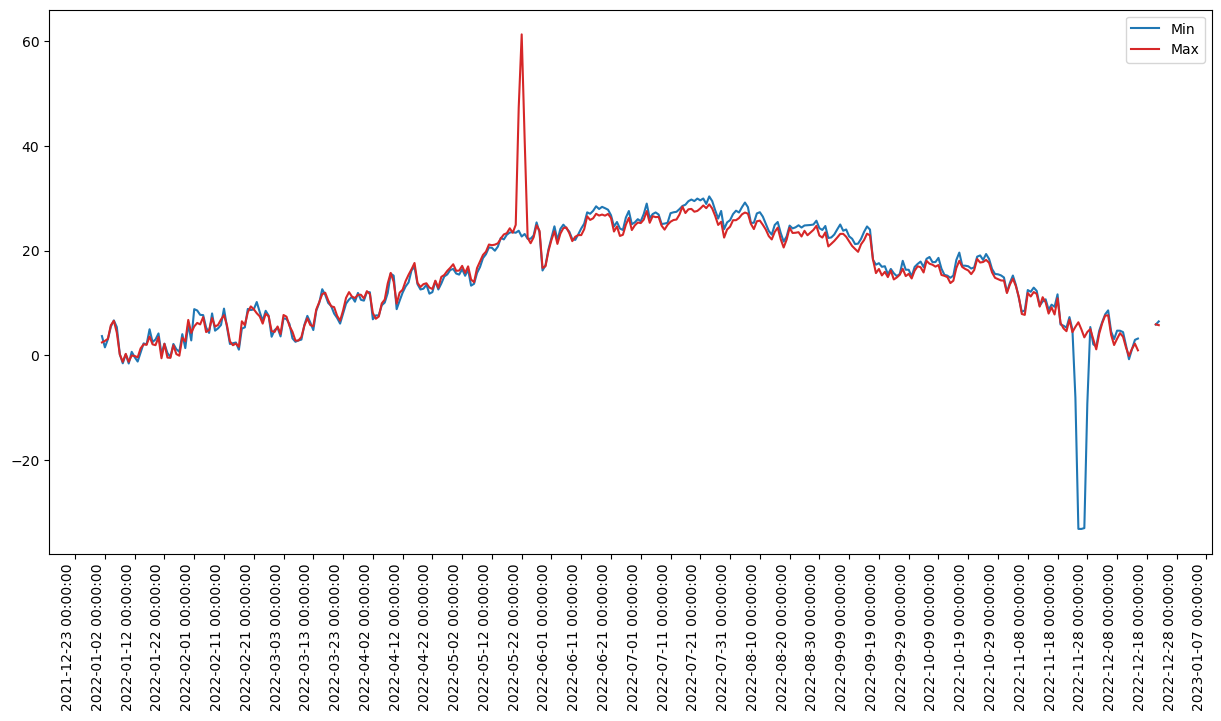

In [83]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min['valore'], '-',  color="tab:blue", label="Min")
plt.plot(sel_sensor_max['data'],sel_sensor_max['valore'], '-',  color="tab:red", label="Max")
plt.legend()

([<matplotlib.axis.XTick at 0x2b8aad31610>,
 [Text(0, 0, 'Max'), Text(1, 0, 'Min')])

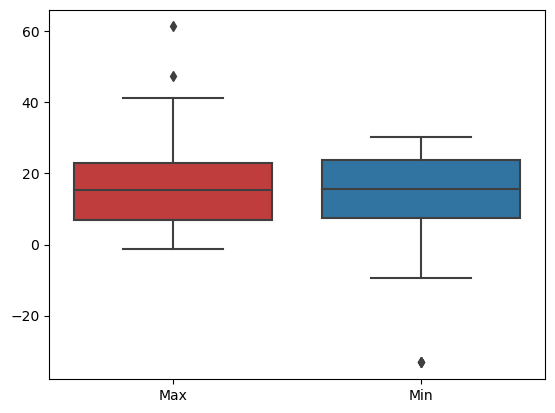

In [84]:
my_pal = {0: "tab:red", 1: "tab:blue"}
sns.boxplot(data=[sel_sensor_max['valore'], sel_sensor_min['valore']], orient="v", palette=my_pal)
plt.xticks([0, 1],["Max","Min"])

In [85]:
import matplotlib.pyplot as plt
import geopandas as gpd 
import numpy as np
from shapely.geometry import box
from scipy.interpolate import griddata

In [86]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.cgb_est, merged_df.cgb_nord), crs="EPSG:32632")

In [87]:
gdf

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop,geometry
0,53,2022-01-01,7.901754,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
1,53,2022-01-02,5.057639,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
2,53,2022-01-03,3.887500,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
3,53,2022-01-04,0.181944,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
4,53,2022-01-05,-1.530556,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123382219671,46.32141528836431,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT,POINT (564213.000 5130098.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69886,32401,2022-12-18,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
69887,32401,2022-12-19,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
69888,32401,2022-12-20,NaN,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)
69889,32401,2022-12-21,1.801639,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578002405918,45.98117244427475,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT,POINT (580679.000 5092483.000)


In [88]:
min_date = merged_df.loc[min_index].data
max_date =merged_df.loc[max_index].data

In [89]:
min_date, max_date

(Timestamp('2022-11-26 00:00:00'), Timestamp('2022-05-22 00:00:00'))

In [90]:
max_gdf = merged_df.loc[merged_df['data'] == max_date]
min_gdf = merged_df.loc[merged_df['data'] == min_date]

In [91]:
max_gdf = gpd.GeoDataFrame(max_gdf, geometry=gpd.points_from_xy(max_gdf.cgb_est, max_gdf.cgb_nord), crs="EPSG:32632")
min_gdf = gpd.GeoDataFrame(min_gdf, geometry=gpd.points_from_xy(min_gdf.cgb_est, min_gdf.cgb_nord), crs="EPSG:32632")

In [92]:
lombardy_gdf = gpd.read_file('lombardia_boundary.gpkg')
lombardy_gdf

,CODICE,NOME,SHAPE_AREA,SHAPE_LEN,aoi,geometry
0,03,LOMBARDIA,2.386817e+10,1.535107e+06,1,"MULTIPOLYGON (((542922.180 4997980.940, 542919..."


Text(0.5, 173.14773259505725, 'East [m]')

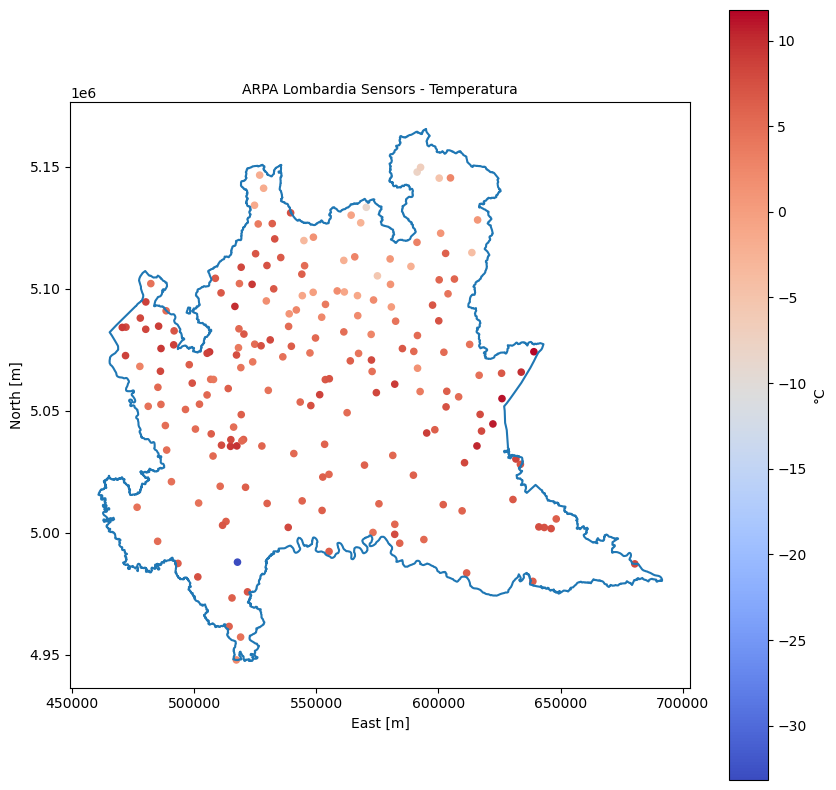

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
min_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

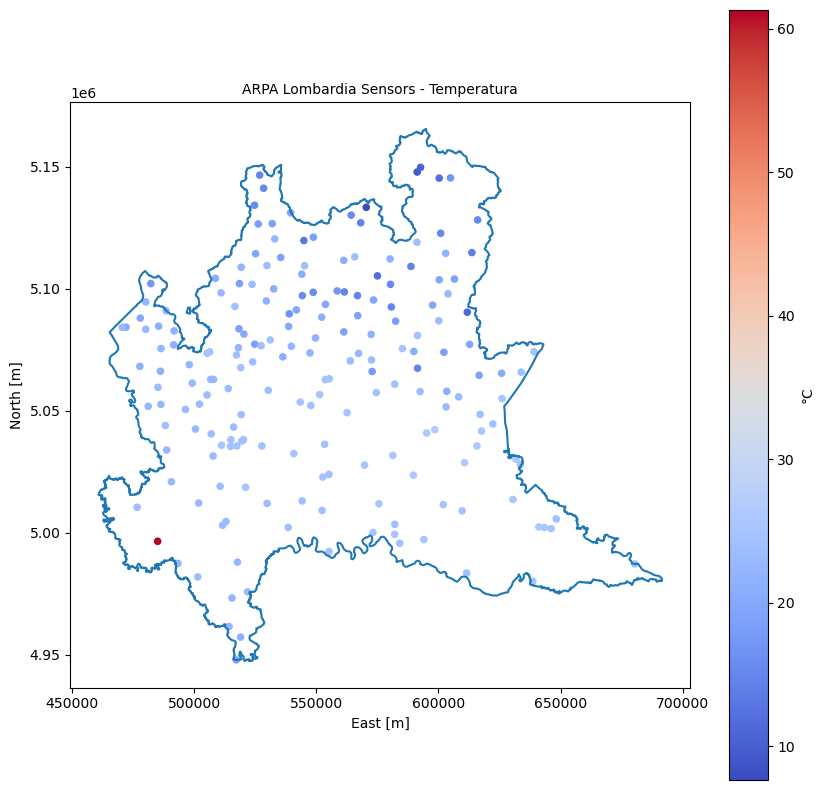

In [94]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

## Other useful functions

In [95]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [96]:
# remove_csv_file(csv_file)